In [4]:
# %load ../interactive/spark.py
#%%
%load_ext autoreload
%autoreload 2

repo='.'
import sys
sys.path.append(f"{repo}/research-transform")

from IPython.core.display import display, HTML
import numpy as np
import pandas as pd
import wmfdata

try:
    spark = wmfdata.spark.get_session(
            app_name='interactive',
            extra_settings={
                'spark.jars.packages': 'org.apache.spark:spark-avro_2.11:2.4.4',
                'spark.sql.shuffle.partitions': 512},
            ship_python_env=False)
except:        
    import findspark
    findspark.init('/usr/lib/spark2')

from pyspark.sql.dataframe import DataFrame
from pyspark.sql import Row, SparkSession, Window
import pyspark.sql.functions as F
import pyspark.sql.types as T


PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


In [14]:
# wav sound files smaller than 10mb from commons
# columns are wmf.mediawiki_wikitext_current and
# wav file bytes
wav = spark.read.format("avro").load('/user/fab/commons_sounds/wav_file/*').cache()
wav.printSchema()


root
 |-- page_id: long (nullable = true)
 |-- page_namespace: integer (nullable = true)
 |-- page_title: string (nullable = true)
 |-- page_redirect_title: string (nullable = true)
 |-- page_restrictions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- user_id: long (nullable = true)
 |-- user_text: string (nullable = true)
 |-- revision_id: long (nullable = true)
 |-- revision_parent_id: long (nullable = true)
 |-- revision_timestamp: string (nullable = true)
 |-- revision_minor_edit: boolean (nullable = true)
 |-- revision_comment: string (nullable = true)
 |-- revision_text_bytes: long (nullable = true)
 |-- revision_text_sha1: string (nullable = true)
 |-- revision_text: string (nullable = true)
 |-- revision_content_model: string (nullable = true)
 |-- revision_content_format: string (nullable = true)
 |-- snapshot: string (nullable = true)
 |-- wiki_db: string (nullable = true)
 |-- file_name: string (nullable = true)
 |-- project: string (nullable =

In [6]:
wav.select(F.length("file_bytes_b64").alias('file_size')).summary().toPandas()

,summary,file_size
0,count,594523
1,mean,195062.95163013038
2,stddev,521379.6885249695
3,min,1780
4,25%,134888
5,50%,156732
6,75%,178576
7,max,13324680


array([[<AxesSubplot:title={'center':'length(file_bytes_b64)'}>]],
      dtype=object)

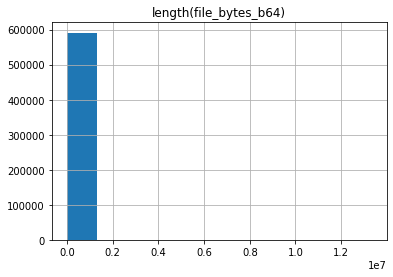

In [10]:
wav.select(F.length("file_bytes_b64")).toPandas().hist()

In [11]:
import base64
from io import BytesIO
from scipy.io import wavfile

@F.udf(returnType="struct<sample_rate:int,length:float>")
def read_wav(file_bytes_b64):
    file = BytesIO(base64.b64decode(file_bytes_b64))
    try:
        sample_rate, data =  wavfile.read(file)
        # data=data.ravel()
        return Row(sample_rate=sample_rate, length=(data.shape[0]/sample_rate))
    except Exception as e:
        # TODO
        # haven't investigated, but this does happen
        print("error loading wav")
        
wav = (wav
    .withColumn('wav', read_wav("file_bytes_b64"))
    .drop("file_bytes_b64")
).cache()


In [13]:
print(wav.select("wav.sample_rate").summary().toPandas())
print(wav.select("wav.length").summary().toPandas())

  summary        sample_rate
0   count             592913
1    mean  45171.87233034189
2  stddev  8275.711620104417
3     min                100
4     25%              44100
5     50%              48000
6     75%              48000
7     max             528000
  summary              length
0   count              592913
1    mean  1.4595011438371486
2  stddev  2.9829845891355955
3     min          0.05825397
4     25%           1.1287981
5     50%                1.23
6     75%                1.48
7     max            637.9452


/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
/home/fab/.conda/envs/2021-04-08T02.22.00_fab/lib/python3.7/site-packages/ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data

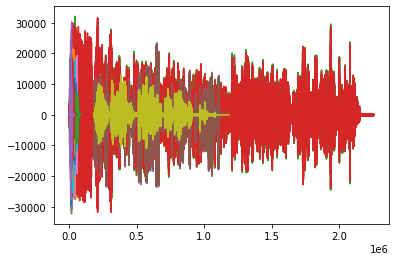

In [17]:
import matplotlib.pyplot as plt
import numpy as np

for r in wav.take(100):
    fb = BytesIO(base64.b64decode(r.file_bytes_b64))    
    try:
        sr, d = wavfile.read(fb)
        plt.plot(d) 
    except:
        pass